In [27]:
import argparse
import pysam
from pathlib import Path
import pandas as pd
import numpy as np

In [28]:
altc = 'altc_circle_seq_3.tsv'
altc = 'altc_circle_seq_3_output.bed'
alt7 = 'alt7_circle_seq_3_output.bed'
rex4 = 'rex4_circle_seq_3_output.bed'
rexc = 'rexc_circle_seq_3_output.bed'

#get the original circle seq dataframes
alt7_orig = "alt7_circle_seq.csv"
altc_orig = "altc_circle_seq.csv"
rex4_orig = "rex4_circle_seq.csv"
rexc_orig = "rexc_circle_seq.csv"


#TSVs for the locations of the potential locations
all_tsvs = {'ALTC':pd.read_csv(altc, sep='\t',  names=['chrom','start','end','name','na','na2','REGION'])[:],
                'ALT7':pd.read_csv(alt7, sep='\t',  names=['chrom','start','end','na','na2','REGION'])[:],
                'REX4':pd.read_csv(rex4, sep='\t',  names=['chrom','start','end','na','na2','REGION'])[:],
                'REXC':pd.read_csv(rexc, sep='\t',  names=['chrom','start','end','na','na2','REGION'])[:]}

#TSVs for the locations of the potential locations
all_circles = {'ALTC':pd.read_csv(altc_orig)[:],
                'ALT7':pd.read_csv(alt7_orig)[:],
                'REX4':pd.read_csv(rex4_orig)[:],
                'REXC':pd.read_csv(rexc_orig)[:]}

edited_dfs = {'ALT7': [None, None],
              'ALTC': [None, None],
              'REXC': [None, None],
              'REX4':[None, None]}

comp_dfs = {'ALT7': [None, None],
            'ALTC': [None, None],
            'REXC': [None, None],
            'REX4':[None, None]}

control_dfs = {'ALT7': [None, None],
               'ALTC': None,
               'REXC': None,
               'REX4': None}


for condition in all_tsvs:
    for replicate in  np.arange(0,2):
        file_path = f"{condition}consensus_indel_rates_hg38_new_con_filtered_mp20{replicate}.csv"  # Construct file name
        edited_dfs[condition][replicate] = pd.read_csv(file_path)

for condition in all_tsvs:
    file_path = f"{condition}consensus_indel_rates_control_hg38_new_con_filtered_mp20.csv"  # Using f-string for readability
    control_dfs[condition] = pd.read_csv(file_path)

for condition in all_tsvs:
    for replicate in np.arange(0,2):
        file_path = f"{condition}_{replicate}consensus_comparison_hg38_new_con_filtered_mp20.csv"  # Using f-string for readability
        comp_dfs[condition][replicate] = pd.read_csv(file_path)

In [29]:
for condition in all_tsvs:
    for replicate in np.arange(0,2):
        
        #combine the df with the circle seq original dataframe which contains the original hg38 coordinates
        original = all_circles[condition]
        new = pd.concat([original, comp_dfs[condition][replicate]], axis=1).reset_index()
        comp_dfs[condition][replicate] = new
        new.to_csv("comparison_and_original_combined.csv", index=False)

In [30]:
#remove all the rows with no replicates
for condition in all_tsvs:
    for replicate in np.arange(0,2):
        df = comp_dfs[condition][replicate]
        if condition == 'REXC':
            df_filtered = df[~((df['Rep1_Reads'] == -1) & (df['Rep2_Reads'] == -1) & (df['index'] != 0))]
        else:
            df_filtered = df[~((df['Rep1_Reads'] == -1) & (df['Rep2_Reads'] == -1))]
        comp_dfs[condition][replicate] = df_filtered

In [31]:
import pandas as pd
import numpy as np

#extract all the unique chromosomes

# Define the chrom_order list
chrom_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 
               'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 
               'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']

# Loop through each condition and replicate
for condition in all_tsvs:
    for replicate in np.arange(0, 2):
        #append the unique contigs to the chrom_order if they are present
        
        # Get unique chromosome names from the 'chrom' column
        unique_chroms = comp_dfs[condition][replicate]['chrom'].unique()
        
        # Filter out chromosomes that are in chrom_order
        nonstandard_chroms = sorted([i for i in unique_chroms if i not in chrom_order])
        print('the nonstandard chromosomes', nonstandard_chroms)
        chrom_order.extend(nonstandard_chroms)

        # Read the DataFrame (assuming file_path is defined earlier)
        
        # Filter the DataFrame to include only rows with 'chrom' values in chrom_order
        filtered_df = comp_dfs[condition][replicate][comp_dfs[condition][replicate]['chrom'].isin(chrom_order)]
        
        # Sort the DataFrame by 'chrom' according to the chrom_order list
        filtered_df['chrom'] = pd.Categorical(filtered_df['chrom'], categories=chrom_order, ordered=True)
        sorted_df = filtered_df.sort_values(by=['chrom', 'start'])
        
        # Update the DataFrame with the filtered and sorted data
        comp_dfs[condition][replicate] = sorted_df


the nonstandard chromosomes []
the nonstandard chromosomes []
the nonstandard chromosomes []
the nonstandard chromosomes []
the nonstandard chromosomes []
the nonstandard chromosomes []
the nonstandard chromosomes []
the nonstandard chromosomes []


In [32]:
from statsmodels.stats.multitest import multipletests

#asjust the p-value
for condition in all_tsvs:
    for replicate in range(2):  # Iterate through two replicates (0 and 1)
        # Get the raw p-values for the current replicate and condition
        raw_p_values = comp_dfs[condition][replicate]['indel p-value']
        
        # Apply Benjamini-Hochberg correction (FDR control)
        reject, adjusted_p_values, _, _ = multipletests(raw_p_values, alpha=0.05, method='fdr_bh')
        
        # Add the adjusted p-values back into the DataFrame
        comp_dfs[condition][replicate]['adjusted indel p-value'] = adjusted_p_values

Chromosome order: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
chr1: offset=0, length=247938360.0
chr2: offset=247938360.0, length=229323327.0
chr3: offset=477261687.0, length=180068194.0
chr4: offset=657329881.0, length=183435885.0
chr5: offset=840765766.0, length=172692682.0
chr6: offset=1013458448.0, length=163663219.0
chr7: offset=1177121667.0, length=156883063.0
chr8: offset=1334004730.0, length=138641322.0
chr9: offset=1472646052.0, length=136523291.0
chr10: offset=1609169343.0, length=126775408.0
chr11: offset=1735944751.0, length=123479554.0
chr12: offset=1859424305.0, length=129683726.0
chr13: offset=1989108031.0, length=103385675.0
chr14: offset=2092493706.0, length=98613694.0
chr15: offset=2191107400.0, length=99628694.0
chr16: offset=2290736094.0, length=56518511.0
chr17: offset=2347254605.0, length=72597476.0
chr18: offset

,chrom,start,p-value,%edited difference,offset_start,-log10 p-value
256,chr1,17901370.0,1.0,NaN,1.790137e+07,-0.0
178,chr1,25661879.0,1.0,0.000000,2.566188e+07,-0.0
177,chr1,41692871.0,1.0,0.000000,4.169287e+07,-0.0
66,chr1,55738887.0,1.0,-0.001873,5.573889e+07,-0.0
7,chr1,67440184.0,1.0,-0.002079,6.744018e+07,-0.0
...,...,...,...,...,...,...
238,chrX,133733302.0,1.0,-0.002381,2.722955e+09,-0.0
192,chrX,133821616.0,1.0,0.000000,2.723043e+09,-0.0
224,chrX,134374258.0,1.0,0.000000,2.723596e+09,-0.0
163,chrX,137222917.0,1.0,NaN,2.726445e+09,-0.0


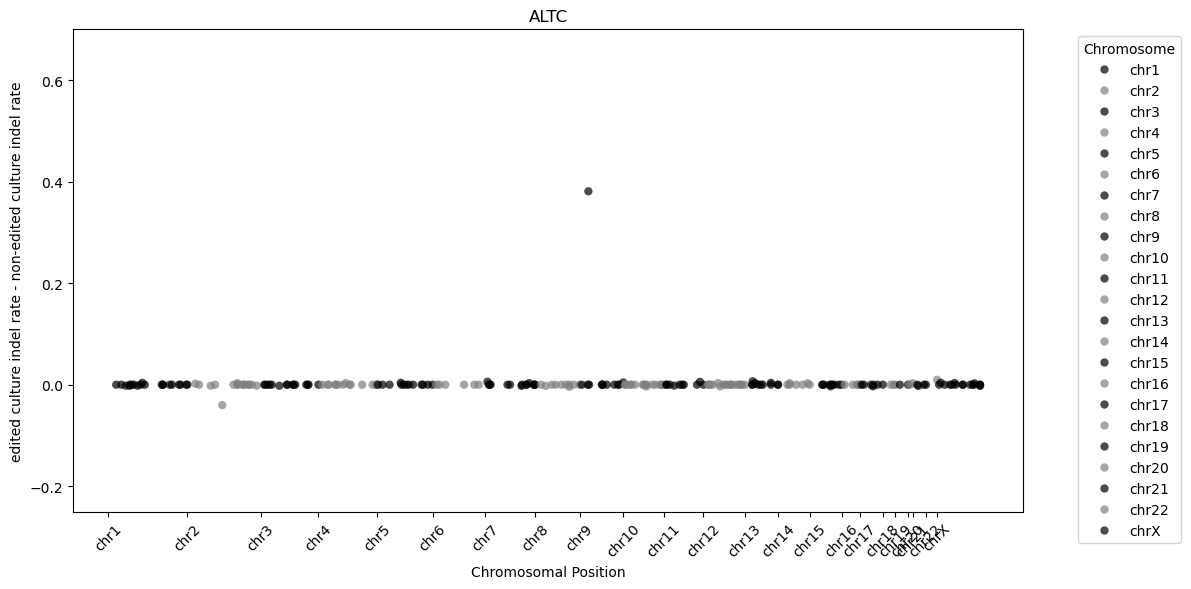

chr1: offset=0, length=247938360.0
chr2: offset=247938360.0, length=229323327.0
chr3: offset=477261687.0, length=180068194.0
chr4: offset=657329881.0, length=183435885.0
chr5: offset=840765766.0, length=172692682.0
chr6: offset=1013458448.0, length=163663219.0
chr7: offset=1177121667.0, length=156883063.0
chr8: offset=1334004730.0, length=138641322.0
chr9: offset=1472646052.0, length=136523291.0
chr10: offset=1609169343.0, length=126775408.0
chr11: offset=1735944751.0, length=123479554.0
chr12: offset=1859424305.0, length=129683726.0
chr13: offset=1989108031.0, length=103385675.0
chr14: offset=2092493706.0, length=98613694.0
chr15: offset=2191107400.0, length=99628694.0
chr16: offset=2290736094.0, length=56518511.0
chr17: offset=2347254605.0, length=72597476.0
chr18: offset=2419852081.0, length=38029399.0
chr19: offset=2457881480.0, length=40490493.0
chr20: offset=2498371973.0, length=14950561.0
chr21: offset=2513322534.0, length=41049661.0
chr22: offset=2554372195.0, length=34849456.0

,chrom,start,p-value,%edited difference,offset_start,-log10 p-value
256,chr1,17901370.0,1.0,NaN,1.790137e+07,-0.0
178,chr1,25661879.0,1.0,0.000000,2.566188e+07,-0.0
177,chr1,41692871.0,1.0,0.000000,4.169287e+07,-0.0
66,chr1,55738887.0,1.0,-0.001873,5.573889e+07,-0.0
7,chr1,67440184.0,1.0,-0.002079,6.744018e+07,-0.0
...,...,...,...,...,...,...
238,chrX,133733302.0,1.0,-0.002381,2.722955e+09,-0.0
192,chrX,133821616.0,1.0,0.000000,2.723043e+09,-0.0
224,chrX,134374258.0,1.0,0.000000,2.723596e+09,-0.0
163,chrX,137222917.0,1.0,NaN,2.726445e+09,-0.0


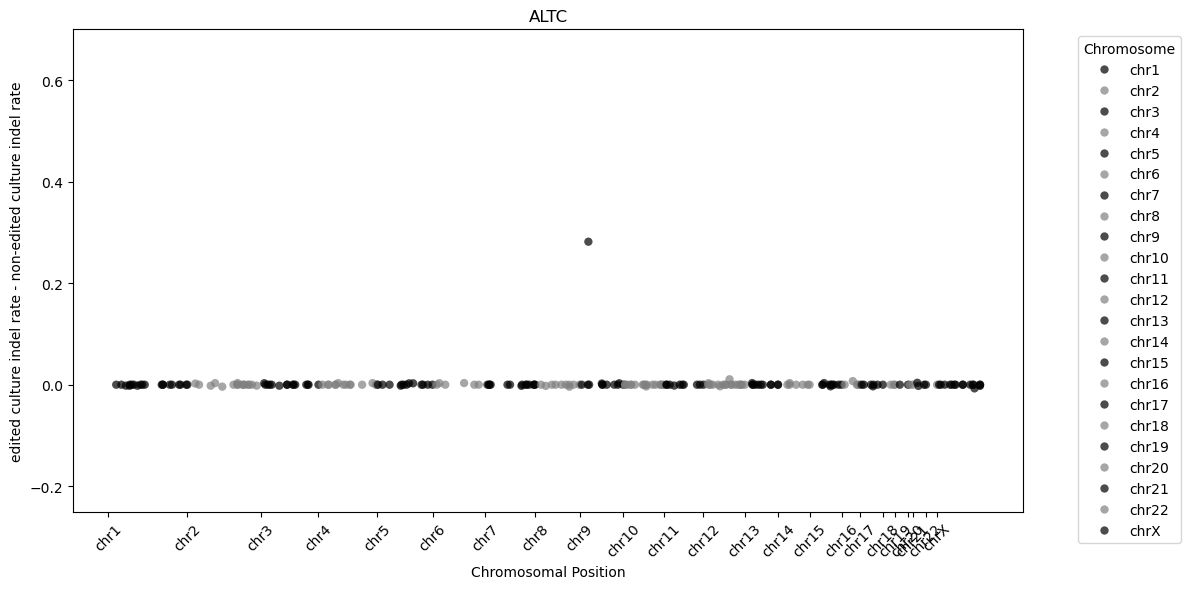

chr1: offset=0, length=247272214.0
chr2: offset=247272214.0, length=242002773.0
chr3: offset=489274987.0, length=194934981.0
chr4: offset=684209968.0, length=187373308.0
chr5: offset=871583276.0, length=180383351.0
chr6: offset=1051966627.0, length=170133953.0
chr7: offset=1222100580.0, length=158595683.0
chr8: offset=1380696263.0, length=145039674.0
chr9: offset=1525735937.0, length=137703968.0
chr10: offset=1663439905.0, length=133527801.0
chr11: offset=1796967706.0, length=133283467.0
chr12: offset=1930251173.0, length=132783426.0
chr13: offset=2063034599.0, length=114125388.0
chr14: offset=2177159987.0, length=106870836.0
chr15: offset=2284030823.0, length=100330552.0
chr16: offset=2384361375.0, length=89816575.0
chr17: offset=2474177950.0, length=83149667.0
chr18: offset=2557327617.0, length=79979583.0
chr19: offset=2637307200.0, length=58072832.0
chr20: offset=2695380032.0, length=64223717.0
chr21: offset=2759603749.0, length=46422440.0
chr22: offset=2806026189.0, length=50721053

,chrom,start,p-value,%edited difference,offset_start,-log10 p-value
963,chr1,994014.0,1.0,-0.001815,9.940140e+05,-0.0
13165,chr1,1022367.0,1.0,0.000000,1.022367e+06,-0.0
13052,chr1,1218324.0,1.0,0.000000,1.218324e+06,-0.0
2733,chr1,1476918.0,1.0,0.000000,1.476918e+06,-0.0
13064,chr1,2301518.0,1.0,-0.001692,2.301518e+06,-0.0
...,...,...,...,...,...,...
703,chrX,151098053.0,1.0,-0.004535,3.007845e+09,-0.0
345,chrX,153003024.0,1.0,0.002358,3.009750e+09,-0.0
12660,chrX,154012390.0,1.0,-0.003396,3.010760e+09,-0.0
12693,chrX,154022238.0,1.0,0.002079,3.010769e+09,-0.0


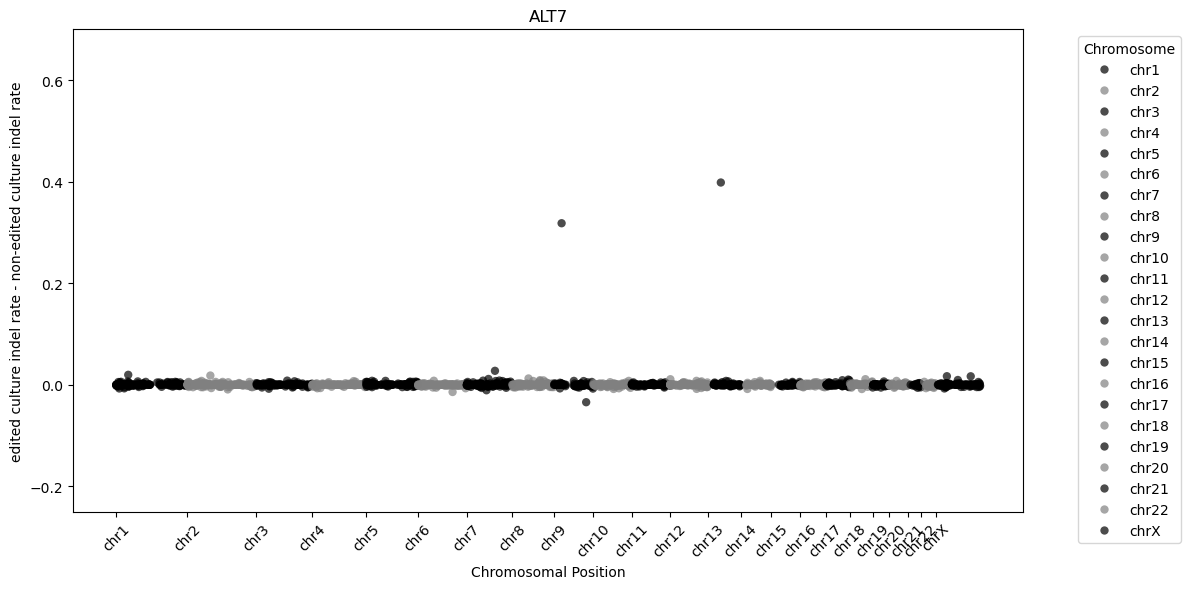

chr1: offset=0, length=247272214.0
chr2: offset=247272214.0, length=242002773.0
chr3: offset=489274987.0, length=194934981.0
chr4: offset=684209968.0, length=187373308.0
chr5: offset=871583276.0, length=180383351.0
chr6: offset=1051966627.0, length=170133953.0
chr7: offset=1222100580.0, length=158595683.0
chr8: offset=1380696263.0, length=145039674.0
chr9: offset=1525735937.0, length=137703968.0
chr10: offset=1663439905.0, length=133527801.0
chr11: offset=1796967706.0, length=133283467.0
chr12: offset=1930251173.0, length=132783426.0
chr13: offset=2063034599.0, length=114125388.0
chr14: offset=2177159987.0, length=106870836.0
chr15: offset=2284030823.0, length=100330552.0
chr16: offset=2384361375.0, length=89816575.0
chr17: offset=2474177950.0, length=83149667.0
chr18: offset=2557327617.0, length=79979583.0
chr19: offset=2637307200.0, length=58072832.0
chr20: offset=2695380032.0, length=64223717.0
chr21: offset=2759603749.0, length=46422440.0
chr22: offset=2806026189.0, length=50721053

,chrom,start,p-value,%edited difference,offset_start,-log10 p-value
963,chr1,994014.0,1.0,0.010843,9.940140e+05,-0.0
13165,chr1,1022367.0,1.0,0.000000,1.022367e+06,-0.0
13052,chr1,1218324.0,1.0,0.000000,1.218324e+06,-0.0
2733,chr1,1476918.0,1.0,0.000000,1.476918e+06,-0.0
13064,chr1,2301518.0,1.0,-0.001692,2.301518e+06,-0.0
...,...,...,...,...,...,...
703,chrX,151098053.0,1.0,-0.004535,3.007845e+09,-0.0
345,chrX,153003024.0,1.0,0.003086,3.009750e+09,-0.0
12660,chrX,154012390.0,1.0,-0.003396,3.010760e+09,-0.0
12693,chrX,154022238.0,1.0,0.000000,3.010769e+09,-0.0


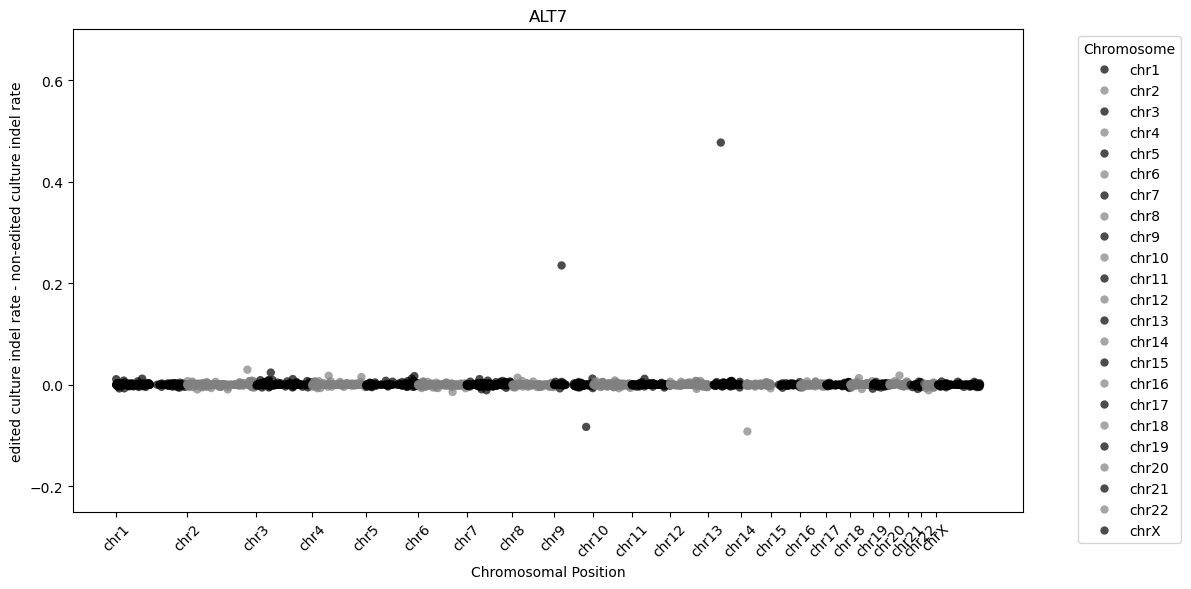

chr1: offset=0, length=246693253.0
chr2: offset=246693253.0, length=232872261.0
chr3: offset=479565514.0, length=188997342.0
chr4: offset=668562856.0, length=189983845.0
chr5: offset=858546701.0, length=179307194.0
chr6: offset=1037853895.0, length=125076526.0
chr7: offset=1162930421.0, length=158083060.0
chr8: offset=1321013481.0, length=133359761.0
chr9: offset=1454373242.0, length=137732053.0
chr10: offset=1592105295.0, length=131451649.0
chr11: offset=1723556944.0, length=123181701.0
chr12: offset=1846738645.0, length=126364745.0
chr13: offset=1973103390.0, length=73547347.0
chr14: offset=2046650737.0, length=32112178.0
chr15: offset=2078762915.0, length=75996330.0
chr16: offset=2154759245.0, length=81200257.0
chr17: offset=2235959502.0, length=83176572.0
chr18: offset=2319136074.0, length=78781830.0
chr19: offset=2397917904.0, length=58279697.0
chr20: offset=2456197601.0, length=62773180.0
chr21: offset=2518970781.0, length=45329598.0
chr22: offset=2564300379.0, length=38470476.0


,chrom,start,p-value,%edited difference,offset_start,-log10 p-value
120,chr1,2283979.0,1.0,0.000000,2.283979e+06,-0.0
79,chr1,3538825.0,1.0,0.000000,3.538825e+06,-0.0
80,chr1,10286404.0,1.0,0.000000,1.028640e+07,-0.0
35,chr1,28501919.0,1.0,0.000000,2.850192e+07,-0.0
23,chr1,32801261.0,1.0,0.000000,3.280126e+07,-0.0
...,...,...,...,...,...,...
1,chr21,45329598.0,1.0,0.000000,2.564300e+09,-0.0
26,chr22,31345397.0,1.0,0.000000,2.595646e+09,-0.0
21,chr22,38470476.0,1.0,0.000000,2.602771e+09,-0.0
92,chrX,56588918.0,1.0,0.002513,2.659360e+09,-0.0


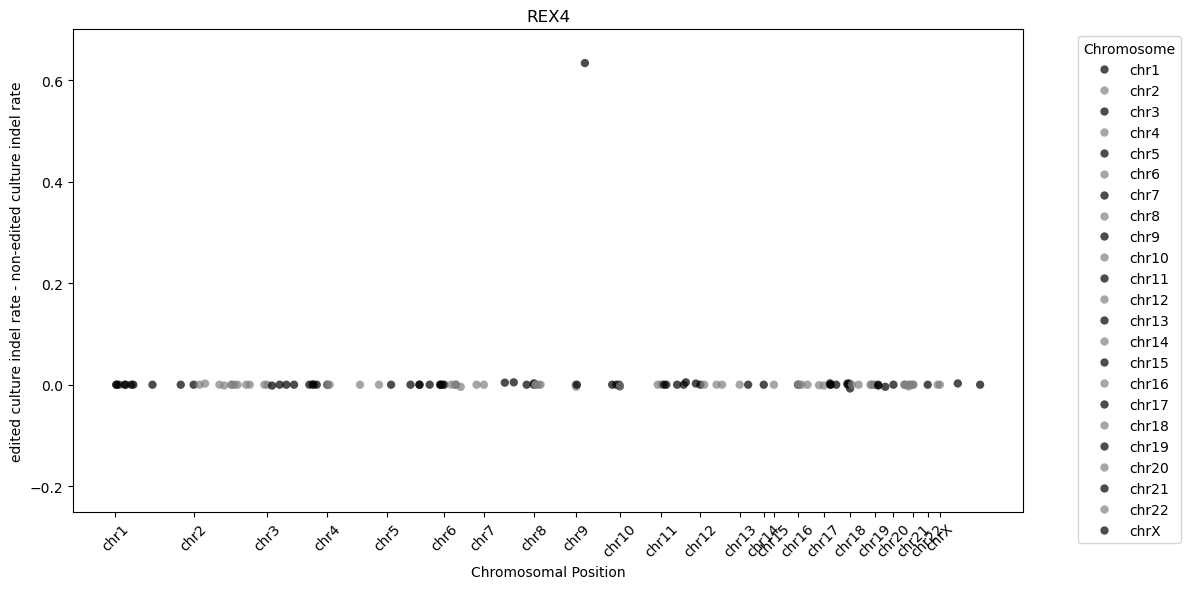

chr1: offset=0, length=246693253.0
chr2: offset=246693253.0, length=232872261.0
chr3: offset=479565514.0, length=188997342.0
chr4: offset=668562856.0, length=189983845.0
chr5: offset=858546701.0, length=179307194.0
chr6: offset=1037853895.0, length=125076526.0
chr7: offset=1162930421.0, length=158083060.0
chr8: offset=1321013481.0, length=133359761.0
chr9: offset=1454373242.0, length=137732053.0
chr10: offset=1592105295.0, length=131451649.0
chr11: offset=1723556944.0, length=123181701.0
chr12: offset=1846738645.0, length=126364745.0
chr13: offset=1973103390.0, length=73547347.0
chr14: offset=2046650737.0, length=32112178.0
chr15: offset=2078762915.0, length=75996330.0
chr16: offset=2154759245.0, length=81200257.0
chr17: offset=2235959502.0, length=83176572.0
chr18: offset=2319136074.0, length=78781830.0
chr19: offset=2397917904.0, length=58279697.0
chr20: offset=2456197601.0, length=62773180.0
chr21: offset=2518970781.0, length=45329598.0
chr22: offset=2564300379.0, length=38470476.0


,chrom,start,p-value,%edited difference,offset_start,-log10 p-value
120,chr1,2283979.0,1.0,0.000000,2.283979e+06,-0.0
79,chr1,3538825.0,1.0,0.000000,3.538825e+06,-0.0
80,chr1,10286404.0,1.0,0.001883,1.028640e+07,-0.0
35,chr1,28501919.0,1.0,0.000000,2.850192e+07,-0.0
23,chr1,32801261.0,1.0,0.000000,3.280126e+07,-0.0
...,...,...,...,...,...,...
1,chr21,45329598.0,1.0,0.000000,2.564300e+09,-0.0
26,chr22,31345397.0,1.0,0.000000,2.595646e+09,-0.0
21,chr22,38470476.0,1.0,0.000000,2.602771e+09,-0.0
92,chrX,56588918.0,1.0,0.000000,2.659360e+09,-0.0


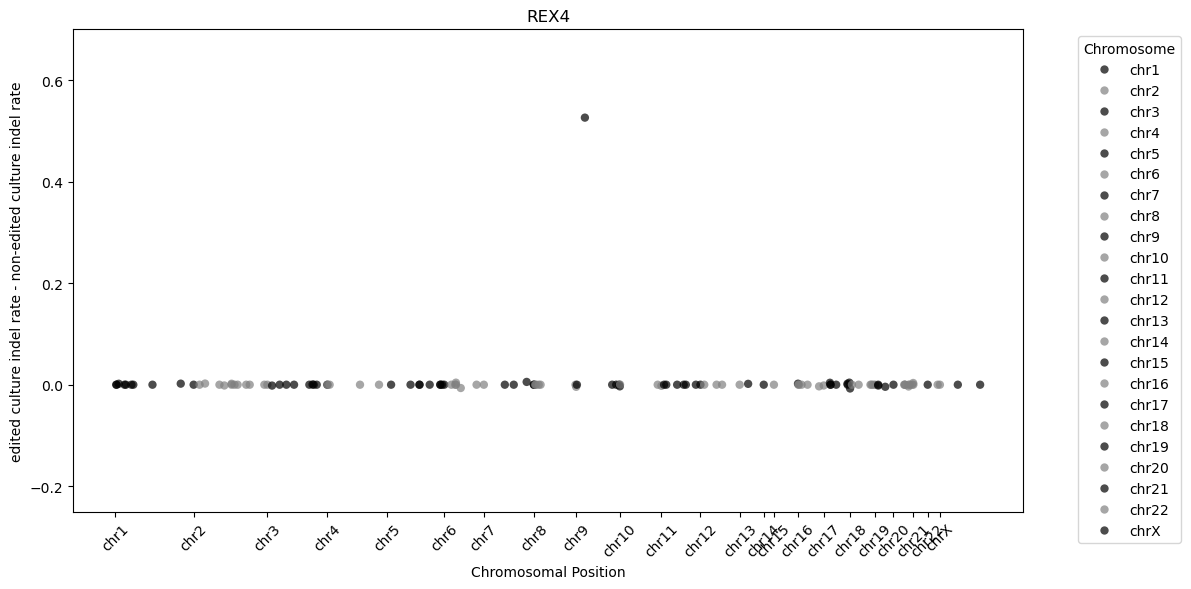

chr1: offset=0, length=247928946.0
chr2: offset=247928946.0, length=241843379.0
chr3: offset=489772325.0, length=196940222.0
chr4: offset=686712547.0, length=187706094.0
chr5: offset=874418641.0, length=180412573.0
chr6: offset=1054831214.0, length=170260834.0
chr7: offset=1225092048.0, length=158856318.0
chr8: offset=1383948366.0, length=144853129.0
chr9: offset=1528801495.0, length=138084057.0
chr10: offset=1666885552.0, length=133308608.0
chr11: offset=1800194160.0, length=134729043.0
chr12: offset=1934923203.0, length=133037670.0
chr13: offset=2067960873.0, length=114198167.0
chr14: offset=2182159040.0, length=105700969.0
chr15: offset=2287860009.0, length=99733318.0
chr16: offset=2387593327.0, length=90047781.0
chr17: offset=2477641108.0, length=83080180.0
chr18: offset=2560721288.0, length=79964582.0
chr19: offset=2640685870.0, length=58118463.0
chr20: offset=2698804333.0, length=64083709.0
chr21: offset=2762888042.0, length=46411766.0
chr22: offset=2809299808.0, length=50731330.

,chrom,start,p-value,%edited difference,offset_start,-log10 p-value
10364,chr1,1021277.0,1.0,0.001558,1.021277e+06,-0.0
653,chr1,1067711.0,1.0,-0.002014,1.067711e+06,-0.0
9975,chr1,1124435.0,1.0,0.000000,1.124435e+06,-0.0
10745,chr1,1185685.0,1.0,-0.002721,1.185685e+06,-0.0
10655,chr1,1198562.0,1.0,0.000000,1.198562e+06,-0.0
...,...,...,...,...,...,...
10186,chrX,154032079.0,1.0,-0.003577,3.014063e+09,-0.0
10775,chrX,154359342.0,1.0,0.000000,3.014390e+09,-0.0
9424,chrX,154486691.0,1.0,-0.008289,3.014518e+09,-0.0
251,chrX,154544262.0,1.0,0.000000,3.014575e+09,-0.0


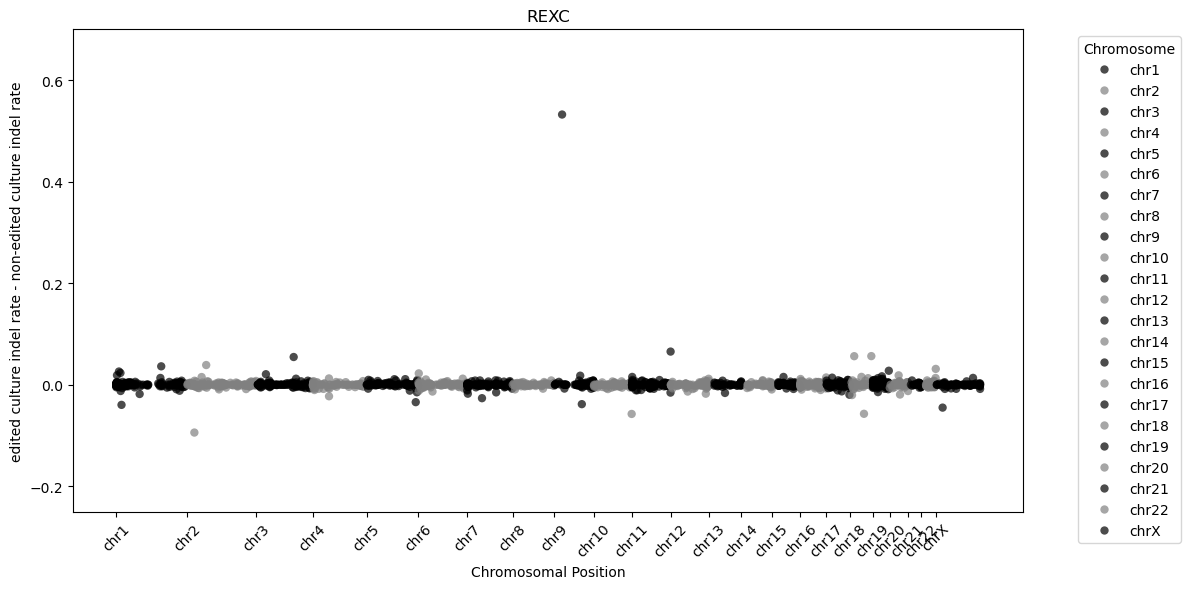

chr1: offset=0, length=247928946.0
chr2: offset=247928946.0, length=241843379.0
chr3: offset=489772325.0, length=196940222.0
chr4: offset=686712547.0, length=187706094.0
chr5: offset=874418641.0, length=180412573.0
chr6: offset=1054831214.0, length=170260834.0
chr7: offset=1225092048.0, length=158856318.0
chr8: offset=1383948366.0, length=144853129.0
chr9: offset=1528801495.0, length=138084057.0
chr10: offset=1666885552.0, length=133308608.0
chr11: offset=1800194160.0, length=134729043.0
chr12: offset=1934923203.0, length=133037670.0
chr13: offset=2067960873.0, length=114198167.0
chr14: offset=2182159040.0, length=105700969.0
chr15: offset=2287860009.0, length=99733318.0
chr16: offset=2387593327.0, length=90047781.0
chr17: offset=2477641108.0, length=83080180.0
chr18: offset=2560721288.0, length=79964582.0
chr19: offset=2640685870.0, length=58118463.0
chr20: offset=2698804333.0, length=64083709.0
chr21: offset=2762888042.0, length=46411766.0
chr22: offset=2809299808.0, length=50731330.

,chrom,start,p-value,%edited difference,offset_start,-log10 p-value
10364,chr1,1021277.0,1.0,0.001799,1.021277e+06,-0.0
653,chr1,1067711.0,1.0,-0.005906,1.067711e+06,-0.0
9975,chr1,1124435.0,1.0,0.000000,1.124435e+06,-0.0
10745,chr1,1185685.0,1.0,-0.004337,1.185685e+06,-0.0
10655,chr1,1198562.0,1.0,0.000000,1.198562e+06,-0.0
...,...,...,...,...,...,...
10186,chrX,154032079.0,1.0,0.002708,3.014063e+09,-0.0
10775,chrX,154359342.0,1.0,0.000000,3.014390e+09,-0.0
9424,chrX,154486691.0,1.0,-0.011052,3.014518e+09,-0.0
251,chrX,154544262.0,1.0,0.000000,3.014575e+09,-0.0


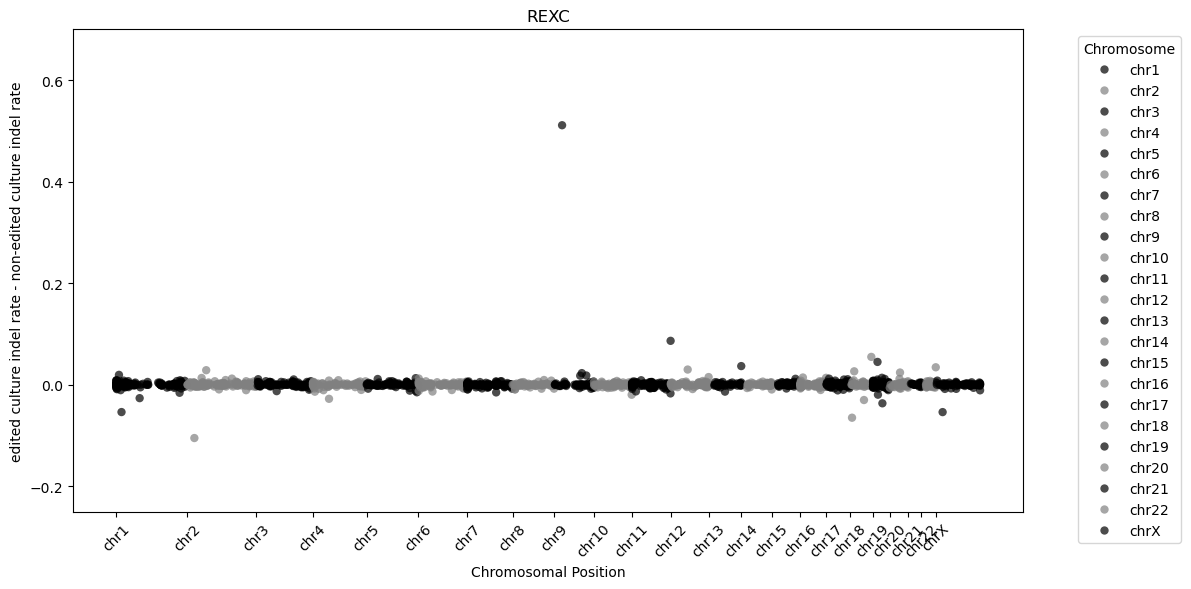

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define alternating black-gray colors
black_gray = ['#000000', '#808080']  # Black and Gray

# Generate dictionary with alternating colors
chromosomes = [f'chr{i}' for i in range(1, 23)]
chromosomes.append("chrX")  # Add chrX
print("Chromosome order:", chromosomes)

custom_palette = {chrom: black_gray[i % 2] for i, chrom in enumerate(chromosomes)}

for condition in all_tsvs:
    for replicate in range(2):
        # Prepare the DataFrame
        data = {
            'chrom': comp_dfs[condition][replicate]['chrom'],
            'start': comp_dfs[condition][replicate]['start'],
            'p-value': comp_dfs[condition][replicate]['adjusted indel p-value']
        }

        df = pd.DataFrame(data)
        df['%edited difference'] = (
            comp_dfs[condition][replicate]['edited indel %'] -
            comp_dfs[condition][replicate]['wt indel %']
        )

        # Remove chrY if present
        df = df[df['chrom'] != 'chrY']

        # Initialize offset dictionary
        offsets = {}
        current_pos = 0

        # Compute offsets chromosome by chromosome
        for chrom in chromosomes:
            chrom_data = df[df['chrom'] == chrom]

            if chrom_data.empty:
                continue  # Skip if chromosome not present

            offsets[chrom] = current_pos
            chrom_end = chrom_data['start'].max()
            current_pos += chrom_end

            print(f"{chrom}: offset={offsets[chrom]}, length={chrom_end}")

        print("Offsets:", offsets)

        # Compute offset_start for plotting
        df['offset_start'] = df.apply(lambda row: row['start'] + offsets[row['chrom']], axis=1)

        # Compute -log10(p-value)
        df['-log10 p-value'] = -np.log10(df['p-value'])

        # Plotting
        plt.figure(figsize=(12, 6))
        display(df)

        sns.scatterplot(
            data=df,
            x="offset_start",
            y="%edited difference",
            hue="chrom",
            palette=custom_palette,
            alpha=0.7,
            edgecolor='none'
        )

        plt.xlabel("Chromosomal Position")
        plt.ylabel("edited culture indel rate - non-edited culture indel rate")
        plt.title(condition)

        # X-ticks: chromosome start positions
        chrom_boundaries = []
        chrom_labels = []

        for chrom in chromosomes:
            if chrom in offsets:
                chrom_boundaries.append(offsets[chrom])
                chrom_labels.append(chrom)

        plt.xticks(ticks=chrom_boundaries, labels=chrom_labels, rotation=45)

        plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.ylim(-0.25, 0.7)

        plt.tight_layout()
        plt.show()


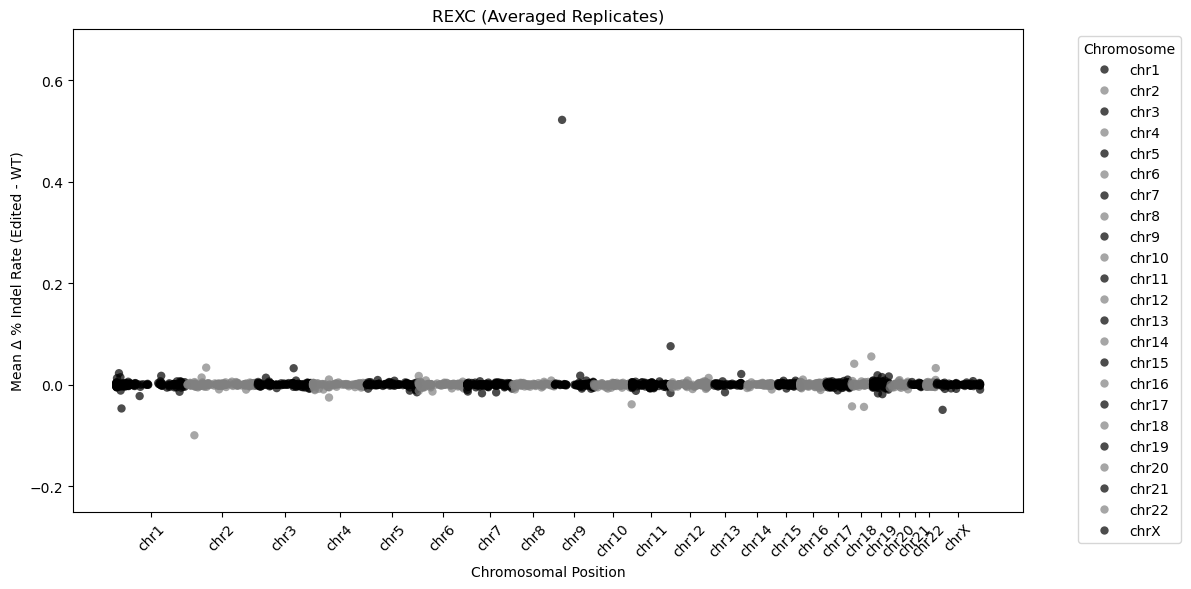

In [59]:
## import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

black_gray = ['#000000', '#808080']
chromosomes = [f'chr{i}' for i in range(1, 23)]
chromosomes.append("chrX")  # Add chrX
custom_palette = {chrom: black_gray[i % 2] for i, chrom in enumerate(chromosomes)}
merged_dfs = {'ALTC': None, 'ALT7': None, 'REXC': None, 'REX4': None}

for condition in ['REXC']:
    dfs = []
    for replicate in np.arange(0, 2):
        df = comp_dfs[condition][replicate][['chrom', 'start', 'adjusted indel p-value', 'wt indel %', 'edited indel %', "indel p-value"]].copy()
        df = df[df['chrom'].isin(chromosomes)]  # Filter out chrX, chrY, etc.
        dfs.append(df)

    # Merge replicates on chrom and start positions
    merged_df= pd.merge(
        dfs[0], dfs[1], 
        on=['chrom', 'start'], 
        suffixes=('_rep1', '_rep2')
    )

    # Average values
    merged_df['%edited average'] = (
        merged_df['edited indel %_rep1'] + merged_df['edited indel %_rep2']
    ) / 2

    #is this valid? prob not
    merged_df['p-value'] = (
        merged_df['adjusted indel p-value_rep1'] + merged_df['adjusted indel p-value_rep2']
    ) / 2

    # Compute offset positions
    offsets = {}
    current_pos = 0
    for chrom in chromosomes:
        chrom_data = merged_df[merged_df['chrom'] == chrom]
        if not chrom_data.empty:
            chrom_end = chrom_data['start'].max()
            offsets[chrom] = current_pos
            current_pos += chrom_end

    merged_df['offset_start'] = merged_df.apply(
        lambda row: row['start'] + offsets[row['chrom']], axis=1
    )

    merged_df['-log10 p-value'] = -np.log10(merged_df['p-value'])
    merged_df['edited difference all'] = merged_df['%edited average'] - merged_df['wt indel %_rep1']
    # Plotting
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=merged_df, x="offset_start", y="edited difference all",
        hue="chrom", palette=custom_palette, alpha=0.7, edgecolor='none'
    )

    plt.xlabel("Chromosomal Position")
    plt.ylabel("Mean Δ % Indel Rate (Edited - WT)")
    plt.title(f"{condition} (Averaged Replicates)")

    # Create chromosome boundary ticks
    chrom_boundaries = []
    chrom_labels = []
    current_pos = 0
    for chrom in chromosomes:
        chrom_data = merged_df[merged_df['chrom'] == chrom]
        if not chrom_data.empty:
            chrom_end = chrom_data['start'].max()
            chrom_boundaries.append(current_pos + chrom_end / 2)
            chrom_labels.append(chrom)
            current_pos += chrom_end

    plt.xticks(ticks=chrom_boundaries, labels=chrom_labels, rotation=45)
    plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(-0.25, 0.7)
    plt.tight_layout()
    plt.show()


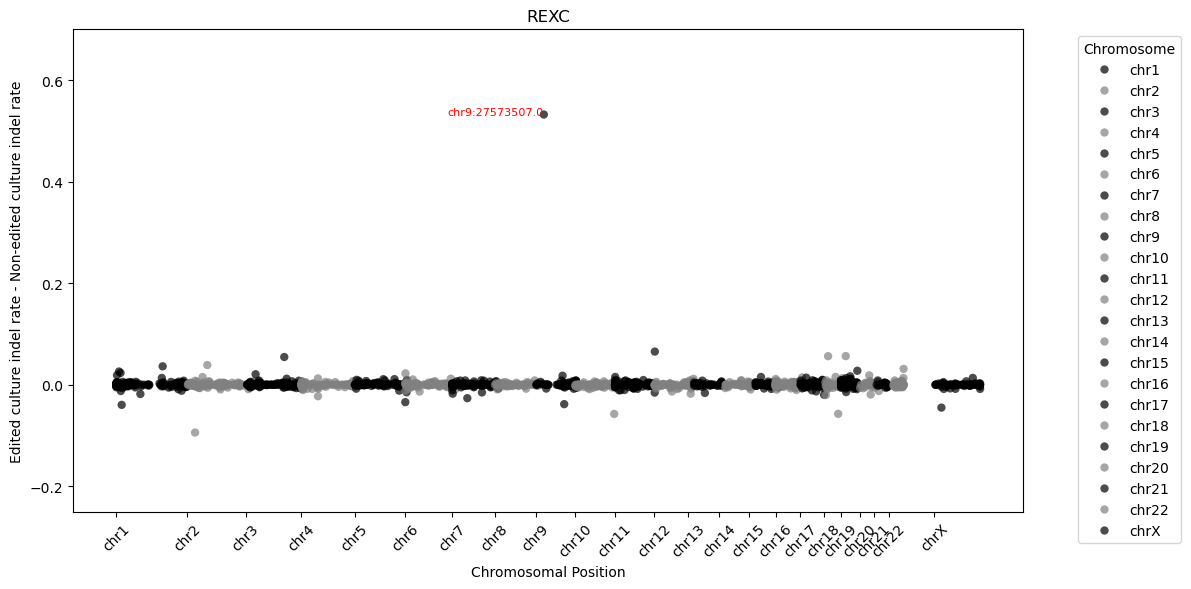

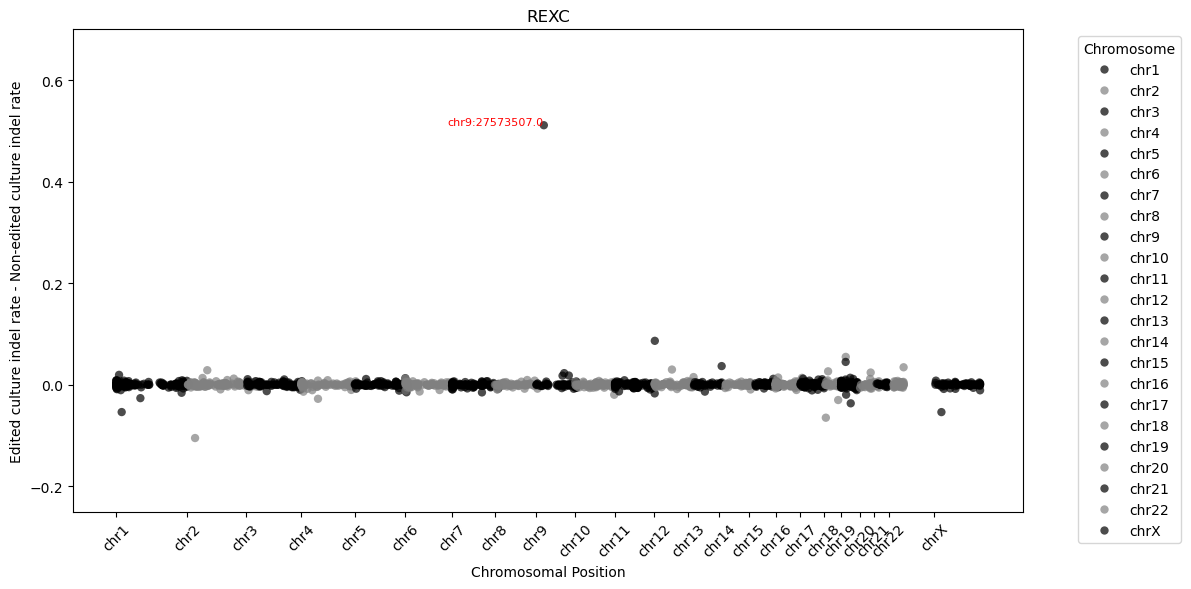

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define alternating black-gray colors
black_gray = ['#000000', '#808080']  # Black and Gray

# Generate dictionary with alternating colors
chromosomes = [f'chr{i}' for i in range(1, 23)]
chromosomes.append("chrX")  # Add chrX
custom_palette = {chrom: black_gray[i % 2] for i, chrom in enumerate(chromosomes)}
# Define significance threshold
significance_threshold = 0.01

for condition in ['REXC']:
    for replicate in np.arange(0, 2):
        
        # Create the data
        data = {
            'chrom': comp_dfs[condition][replicate]['chrom'],
            'start': comp_dfs[condition][replicate]['start'],
            'p-value': comp_dfs[condition][replicate]['adjusted indel p-value']
        }
        
        df = pd.DataFrame(data)
        df['%edited difference'] = comp_dfs[condition][replicate]['edited indel %'] - comp_dfs[condition][replicate]['wt indel %']

        # Initialize offsets dictionary
        offsets = {}
        current_pos = 0
        
        # Iterate through each unique chromosome
        for chrom in df['chrom'].unique():
            chrom_data = df[df['chrom'] == chrom]
            chrom_end = chrom_data['start'].max()  # Max position = end position for this chromosome
            
            offsets[chrom] = current_pos + chrom_end  # Store cumulative position
            current_pos += chrom_end  # Update for next chromosome
        
        df['offset_start'] = df.apply(lambda row: row['start'] + offsets[row['chrom']], axis=1)

        # Transform p-values to -log10(p-value)
        df['-log10 p-value'] = -np.log10(df['p-value'])
        
        # Identify significant points (adjusted p-value < threshold)
        significant_df = df[df['p-value'] < significance_threshold]

        # Plot the Manhattan plot
        plt.figure(figsize=(12, 6))
        
        # Create scatter plot and remove edgecolor (no outline for dots)
        sns.scatterplot(data=df, x="offset_start", y="%edited difference", hue="chrom", 
                        palette=custom_palette, alpha=0.7, edgecolor='none')
        
        # Label the plot
        plt.xlabel("Chromosomal Position")
        plt.ylabel("Edited culture indel rate - Non-edited culture indel rate")
        plt.title(condition)
        
        # Customize the X-axis
        chrom_boundaries = []
        chrom_labels = []
        current_pos = 0
        for chrom in df['chrom'].unique():
            chrom_data = df[df['chrom'] == chrom]
            chrom_end = chrom_data['start'].max()
            chrom_boundaries.append(chrom_end + current_pos)
            chrom_labels.append(chrom)
            current_pos += chrom_end
        
        plt.xticks(ticks=chrom_boundaries, labels=chrom_labels, rotation=45)

        # Label significant points
        for _, row in significant_df.iterrows():
            plt.text(row['offset_start'], row['%edited difference'], 
                     f"{row['chrom']}:{row['start']}", fontsize=8, ha='right', color='red')

        # Add a legend
        plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.ylim(-0.25, 0.7)
        
        # Show the plot
        plt.tight_layout()
        plt.show()


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

black_gray = ['#000000', '#808080']  # Black and Gray
chromosomes = [f'chr{i}' for i in range(1, 23)]
custom_palette = {chrom: black_gray[i % 2] for i, chrom in enumerate(chromosomes)}
significance_threshold = 0.05

for condition in ['ALTC']:
    for replicate in np.arange(0, 2):
        comp_dfs = merged_df
        # Create the data
        data = {
            'chrom': comp_dfs['chrom'],
            'start': comp_dfs['start'],
            'p-value_1': comp_dfs['adjusted indel p-value_rep1'],
            'p-value_2': comp_dfs['adjusted indel p-value_rep2'],
            'orig p-value_1': comp_dfs['indel p-value_rep2'],
            'orig p-value_2': comp_dfs['indel p-value_rep2']
        }

        df = pd.DataFrame(data)
        df['edited difference all'] = merged_df['edited difference all']

        # Initialize offsets dictionary
        offsets = {}
        current_pos = 0
        
        # Iterate through each unique chromosome
        for chrom in df['chrom'].unique():
            chrom_data = df[df['chrom'] == chrom]
            chrom_end = chrom_data['start'].max()  # Max position = end position for this chromosome
            
            offsets[chrom] = current_pos + chrom_end  # Store cumulative position
            current_pos += chrom_end  # Update for next chromosome
        
        df['offset_start'] = df.apply(lambda row: row['start'] + offsets[row['chrom']], axis=1)
        
        significant_df = df[(df['p-value_1'] < significance_threshold) & (df['p-value_2'] < significance_threshold)]
        plt.figure(figsize=(12, 6))
        
        # Create scatter plot and remove edgecolor (no outline for dots)
        sns.scatterplot(data=df, x="offset_start", y="edited difference all", hue="chrom", 
                        palette=custom_palette, alpha=0.7, edgecolor='none')
       
        # Label the plot
        plt.xlabel("Chromosomal Position")
        plt.ylabel("Average Edited indel rate - Non-edited indel rate (2 replicates)")
        plt.title(condition)
        
        # Customize the X-axis
        chrom_boundaries = []
        chrom_labels = []
        current_pos = 0
        for chrom in df['chrom'].unique():
            chrom_data = df[df['chrom'] == chrom]
            chrom_end = chrom_data['start'].max()
            chrom_boundaries.append(chrom_end + current_pos)
            chrom_labels.append(chrom)
            current_pos += chrom_end
        
        plt.xticks(ticks=chrom_boundaries, labels=chrom_labels, rotation=45)

        # Label significant points
        for _, row in significant_df.iterrows():
            plt.text(row['offset_start'], row['edited difference all'] , 
                     f"{row['chrom']}:{row['start']}", fontsize=8, ha='right', color='red')

        # Add a legend
        plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.ylim(-0.25, 0.7)
        
        # Show the plot
        plt.tight_layout()
        plt.show()


ValueError: The palette dictionary is missing keys: {'chrX'}

<Figure size 1200x600 with 0 Axes>